In [15]:
# autorelead libraries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
import time
import random
import pickle
import argparse

import numpy as np
import scipy.sparse as sp
import scipy.signal as sig
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from config import get_config
from dataset import data_loader
from neural_methods.model.ContrastPhys import ContrastPhys
from neural_methods.model.PhysNet import PhysNet_padding_Encoder_Decoder_MAX
from neural_methods.model.FactorizePhys.FactorizePhys import FactorizePhys
from neural_methods.model.FactorizePhys.FactorizePhysBig import FactorizePhysBig
from neural_methods.model.PhysMamba import PhysMamba
from neural_methods.model.ContrastFusion import ContrastFusion
from neural_methods.model.PhysFormer import ViT_ST_ST_Compact3_TDC_gra_sharp
from neural_methods.model.RhythmFormer import RhythmFormer

In [36]:
def calcMetrics(input_data, sampFreq, B, window_size=None, use_harmonic=False, normalize=False):
    # define goodness parameters
    B1 = 0.75 # low cutoff
    B2 = 3 # high cutoff

    if window_size is None:
        pulseCalcLength = len(input_data)
    else:
        pulseCalcLength = np.uint32(window_size/(1.0/sampFreq))
    pulseRate_result = np.empty(len(input_data)-pulseCalcLength + 1)
    goodnessMetric_result = np.empty(len(input_data)-pulseCalcLength + 1)

    for i in range(0, len(pulseRate_result)):
        window = input_data[i:i+pulseCalcLength]
        # sigFreq, sigPower = sig.periodogram(window, fs=sampFreq, nfft=180000)
        sigFreq, sigPower = sig.welch(x=window, nperseg=len(window)//3, fs=sampFreq, nfft=180000)
        maskFreq = (sigFreq > B1)&(sigFreq<B2)
        # sigFreq = sigFreq[maskFreq]
        sigPower = sigPower * maskFreq
        if use_harmonic:
            # harmonic PSD
            harmonicsigPower = sigPower[::2]
            harmonicsigPower = np.pad(harmonicsigPower, (0, len(sigPower) - len(harmonicsigPower)))
            # find peak frequency
            peakFreq = sigFreq[np.argmax(sigPower + harmonicsigPower)]
        else:
            peakFreq = sigFreq[np.argmax(sigPower)]
        pulseRate = 60.0*peakFreq
        pulseRate_result[i] = pulseRate
        # compute goodness
        aroundPulseRate = (sigFreq > peakFreq - B) & (sigFreq < peakFreq + B)
        withinBandpass = (sigFreq >= B1) & (sigFreq <= B2)
        powerPulseRate = np.sum(sigPower[aroundPulseRate])
        powerAll = np.sum(sigPower[withinBandpass])
        if normalize:
            goodnessMetric_result[i] = powerPulseRate / powerAll
        else:
            goodnessMetric_result[i] = powerPulseRate / (powerAll - powerPulseRate)
    timestamps = np.arange(len(pulseRate_result))
    return timestamps, goodnessMetric_result, pulseRate_result

def custom_detrend(sig, Lambda):
    """custom_detrend(sig, Lambda) -> filtered_signal
    This function applies a detrending filter.
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
    *Parameters*
      ``sig`` (1d numpy array):
        The sig where you want to remove the trend.
      ``Lambda`` (int):
        The smoothing parameter.
    *Returns*
      ``filtered_signal`` (1d numpy array):
        The detrended sig.
    """
    signal_length = sig.shape[0]

    # observation matrix
    H = np.identity(signal_length)

    # second-order difference matrix

    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = sp.spdiags(diags_data, diags_index, (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot((H - np.linalg.inv(H + (Lambda ** 2) * np.dot(D.T, D))), sig)
    return filtered_signal

def pulse_rate_from_power_spectral_density(pleth_sig: np.array, FS: float,
                                           LL_PR: float, UL_PR: float,
                                           BUTTER_ORDER: int = 6,
                                           DETREND: bool = False,
                                           FResBPM: float = 0.1,
                                           HARMONIC: bool = False,
                                           WELCH = True) -> float:
    """ Function to estimate the pulse rate from the power spectral density of the plethysmography sig.

    Args:
        pleth_sig (np.array): Plethysmography sig.
        FS (float): Sampling frequency.
        LL_PR (float): Lower cutoff frequency for the butterworth filtering.
        UL_PR (float): Upper cutoff frequency for the butterworth filtering.
        BUTTER_ORDER (int, optional): Order of the butterworth filter. Give None to skip filtering. Defaults to 6.
        DETREND (bool, optional): Boolena Flag for executing cutsom_detrend. Defaults to False.
        FResBPM (float, optional): Frequency resolution. Defaults to 0.1.

    Returns:
        pulse_rate (float): _description_
    

    Daniel McDuff, Ethan Blackford, January 2019
    Copyright (c)
    Licensed under the MIT License and the RAIL AI License.
    """

    N = (60*FS)/FResBPM

    # Detrending + nth order butterworth + periodogram
    if DETREND:
        pleth_sig = custom_detrend(pleth_sig, 100)
    if BUTTER_ORDER:
        [b, a] = sig.butter(BUTTER_ORDER, [LL_PR/60, UL_PR/60], btype='bandpass', fs = FS)
    pleth_sig = sig.filtfilt(b, a, np.double(pleth_sig))
    
    # Calculate the PSD and the mask for the desired range
    if WELCH:
        F, Pxx = sig.welch(x=pleth_sig, nperseg=len(pleth_sig)//3, nfft=N, fs=FS)
    else:
        F, Pxx = sig.periodogram(x=pleth_sig,  nfft=N, fs=FS);  
    FMask = (F >= (LL_PR/60)) & (F <= (UL_PR/60))
    
    # Calculate predicted pulse rate:
    FRange = F * FMask
    PRange = Pxx * FMask

    if HARMONIC:
      harmonicsigPower = PRange[::2]
      harmonicsigPower = np.pad(harmonicsigPower, (0, len(PRange) - len(harmonicsigPower)))
      harmonicsigPower[0] = 0
      MaxInd = np.argmax(PRange+harmonicsigPower)
    else:
      MaxInd = np.argmax(PRange)
    pulse_rate_freq = FRange[MaxInd]
    pulse_rate = pulse_rate_freq*60
            
    return pulse_rate

In [58]:
class Args:
    # config_file = 'configs/train_configs/CogPhys_CONTRASTPHYS_BASIC.yaml'
    # config_file = 'configs/train_configs/CogPhys_PHYSNET_BASIC.yaml'
    # config_file = 'configs/train_configs/CogPhys_FactorizePhys_BASIC.yaml'
    # config_file = 'configs/train_configs/CogPhys_PHYSMAMBA_BASIC.yaml'
    # config_file = 'configs/train_configs/CogPhys_Fusion_BASIC.yaml'
    #config_file = 'configs/train_configs/CogPhys_PHYSFORMER_BASIC.yaml'
    config_file = 'configs/train_configs/CogPhys_RHYTHMFORMER_BASIC.yaml'
    cached_path = None
    preprocess = None
    lr = None
    model_file_name = None

args = Args()
config = get_config(args)
# print('Configuration:')
# print(config, end='\n\n')
data_loader_dict = dict() # dictionary of data loaders 
train_loader = data_loader.CogPhysLoader.CogPhysLoader
print(config.DEVICE)
train_data_loader = train_loader(
    name="train",
    data_path=config.TRAIN.DATA.DATA_PATH,
    config_data=config.TRAIN.DATA,
    device=config.DEVICE)
data_loader_dict['train'] = DataLoader(
    dataset=train_data_loader,
    num_workers=2,
    batch_size=2,
    shuffle=True,
)
print(); print()

valid_loader = data_loader.CogPhysLoader.CogPhysLoader
print(config.DEVICE)
valid_data_loader = valid_loader(
    name="valid",
    data_path=config.VALID.DATA.DATA_PATH,
    config_data=config.VALID.DATA,
    device=config.DEVICE)
data_loader_dict['valid'] = DataLoader(
    dataset=valid_data_loader,
    num_workers=2,
    batch_size=2,
    shuffle=True,
)
print(); print()

test_loader = data_loader.CogPhysLoader.CogPhysLoader
print(config.DEVICE)
test_data_loader = test_loader(
    name="test",
    data_path=config.TEST.DATA.DATA_PATH,
    config_data=config.TEST.DATA,
    device=config.DEVICE)
data_loader_dict['test'] = DataLoader(
    dataset=test_data_loader,
    num_workers=4,
    batch_size=3,
    shuffle=False,
)

=> Merging a config file from configs/train_configs/CogPhys_RHYTHMFORMER_BASIC.yaml
cuda:0
Excluding ['v19_still'] files from the dataset due to corrupted nir video
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

train Preprocessed Dataset Length: 1764



cuda:0
Excluding ['v19_still'] files from the dataset due to corrupted nir video
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

valid Preprocessed Dataset Length: 144



cuda:0
Excluding ['v19_still'] files from the dataset due to corrupted nir video
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

test Preprocessed Dataset Length: 720



In [59]:
test_data_loader.input_preproc, test_data_loader.label_preproc, test_data_loader.input_keys, test_data_loader.label_keys

([['NormAndFloat']], [['Standardize', 'Downsample']], ['nir'], ['ppg'])

In [60]:
torch.cuda.empty_cache()

In [61]:
load_path = '/home/dg73/CogPhys/runs/exp/NIR_RhythmFormer/PreTrainedModels/CogPhys_rPPG_ch1_RhythmFormer_Epoch29.pth'


if config.MODEL.NAME == 'ContrastPhys':
    model = ContrastPhys(S=config.MODEL.CONTRASTPHYS.S).to(config.DEVICE).eval()
elif config.MODEL.NAME == 'ContrastFusion':
    model = ContrastFusion(S=config.MODEL.CONTRASTFUSION.S).to(config.DEVICE).eval()
    model = torch.nn.DataParallel(model, device_ids=list(range(1)))
elif config.MODEL.NAME == 'Physnet':
    model = PhysNet_padding_Encoder_Decoder_MAX(frames=900).to(config.DEVICE).eval()
elif config.MODEL.NAME == 'PhysMamba':
    model = PhysMamba(frames=900).to(config.DEVICE).eval()
    model = torch.nn.DataParallel(model, device_ids=list(range(1)))
elif config.MODEL.NAME == 'FactorizePhys':
    md_config = {}
    md_config["FRAME_NUM"] = config.MODEL.FactorizePhys.FRAME_NUM
    md_config["MD_TYPE"] = config.MODEL.FactorizePhys.MD_TYPE
    md_config["MD_FSAM"] = False
    md_config["MD_TRANSFORM"] = config.MODEL.FactorizePhys.MD_TRANSFORM
    md_config["MD_S"] = config.MODEL.FactorizePhys.MD_S
    md_config["MD_R"] = config.MODEL.FactorizePhys.MD_R
    md_config["MD_STEPS"] = config.MODEL.FactorizePhys.MD_STEPS
    md_config["MD_INFERENCE"] = config.MODEL.FactorizePhys.MD_INFERENCE
    md_config["MD_RESIDUAL"] = config.MODEL.FactorizePhys.MD_RESIDUAL
    if config.MODEL.FactorizePhys.TYPE.lower() == "standard": model_object = FactorizePhys
    elif config.MODEL.FactorizePhys.TYPE.lower() == "big": model_object = FactorizePhysBig
    model = model_object(frames=config.MODEL.FactorizePhys.FRAME_NUM, md_config=md_config, 
                         in_channels=config.MODEL.FactorizePhys.CHANNELS,
                         dropout=config.MODEL.DROP_RATE, device=config.DEVICE).eval()
    model = torch.nn.DataParallel(model, device_ids=list(range(1)))
elif config.MODEL.NAME == 'PhysFormer':
    model = ViT_ST_ST_Compact3_TDC_gra_sharp(
                image_size=(config.TRAIN.DATA.COGPHYS.SEQ_LENGTH, config.TRAIN.DATA.COGPHYS.H_SIZE,config.TRAIN.DATA.COGPHYS.W_SIZE), 
                patches=(config.MODEL.PHYSFORMER.PATCH_SIZE,) * 3, 
                dim=config.MODEL.PHYSFORMER.DIM, 
                ff_dim=config.MODEL.PHYSFORMER.FF_DIM, 
                num_heads=config.MODEL.PHYSFORMER.NUM_HEADS,
                num_layers=config.MODEL.PHYSFORMER.NUM_LAYERS, 
                dropout_rate=config.MODEL.DROP_RATE, 
                theta=config.MODEL.PHYSFORMER.THETA).to(config.DEVICE).eval()
elif config.MODEL.NAME == 'RhythmFormer':
    model = RhythmFormer().to(config.DEVICE).eval()
else:
    raise NotImplementedError(f"Model {config.MODEL.NAME} not implemented.")


state_dict = torch.load(load_path, map_location=config.DEVICE)
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model = torch.nn.DataParallel(model, device_ids=list(range(config.NUM_OF_GPU_TRAIN)))


In [62]:
def forward_pass(model, img_data, gra_sharp=2.0):
    if config.MODEL.NAME == 'ContrastPhys':
        out = model(img_data)[0][-1].squeeze(0).cpu().numpy()
    elif config.MODEL.NAME == 'ContrastFusion':
        out = model(img_data)[0][-1].squeeze(0).cpu().numpy()
    elif config.MODEL.NAME == 'Physnet':
        out = model(img_data)[0].squeeze(0).cpu().numpy()
    elif config.MODEL.NAME == 'PhysMamba':
        out = model(img_data).squeeze(0).cpu().numpy()
    elif config.MODEL.NAME == 'FactorizePhys':
        out = model(img_data)[0].squeeze(0).cpu().numpy()
    elif config.MODEL.NAME == 'PhysFormer':
        out = model(img_data, gra_sharp)[0][-1].squeeze(0).cpu().numpy()
    elif config.MODEL.NAME == 'RhythmFormer':
        out = model(img_data).squeeze(0).cpu().numpy()
    else:
        raise NotImplementedError(f"Model {config.MODEL.NAME} not implemented.")
    return out

In [63]:
all_pred = []
all_gt = []
all_participant_task_chunk_list = []
for i in range(0, len(test_data_loader), 12):
    for j in [[0, 1, 4], [5, 6, 7], [8, 9, 10], [11, 2, 3]]:
        img = []
        label = []
        participant_task_list = []
        chunk_id_list = []
        with torch.no_grad():
            for k in j:
                img_sample, label_sample, participant_task, chunk_id = test_data_loader[i+k]
                participant_task_list.append(participant_task)
                chunk_id_list.append(int(chunk_id))
                img.append(img_sample.to(config.DEVICE))
                label.extend(label_sample.squeeze(0).cpu().numpy().tolist())
            img = torch.cat(img, dim=1).unsqueeze(0)
            pred = forward_pass(model, img)
        if "v23_read" == participant_task:
            print("Skipping")
            continue
        ##################
        assert participant_task_list[0] == participant_task_list[1]
        assert chunk_id_list[0] == chunk_id_list[1]-1
        ##################
        pred = np.array(pred)
        label = np.array(label)
        all_participant_task_chunk_list.append((participant_task_list[0], chunk_id_list)) 
        all_pred.append(pred)
        all_gt.append(label)
        print(participant_task_list[0], chunk_id_list)

v22_pattern_rest [0, 1, 2]
v22_pattern_rest [3, 4, 5]
v22_pattern_rest [6, 7, 8]
v22_pattern_rest [9, 10, 11]
v27_number [0, 1, 2]
v27_number [3, 4, 5]
v27_number [6, 7, 8]
v27_number [9, 10, 11]
v37_read [0, 1, 2]
v37_read [3, 4, 5]
v37_read [6, 7, 8]
v37_read [9, 10, 11]
v32_read_rest [0, 1, 2]
v32_read_rest [3, 4, 5]
v32_read_rest [6, 7, 8]
v32_read_rest [9, 10, 11]
v38_still [0, 1, 2]
v38_still [3, 4, 5]
v38_still [6, 7, 8]
v38_still [9, 10, 11]
v10_read_rest [0, 1, 2]
v10_read_rest [3, 4, 5]
v10_read_rest [6, 7, 8]
v10_read_rest [9, 10, 11]
v27_pattern_rest [0, 1, 2]
v27_pattern_rest [3, 4, 5]
v27_pattern_rest [6, 7, 8]
v27_pattern_rest [9, 10, 11]
v32_pattern_rest [0, 1, 2]
v32_pattern_rest [3, 4, 5]
v32_pattern_rest [6, 7, 8]
v32_pattern_rest [9, 10, 11]
v37_pattern_rest [0, 1, 2]
v37_pattern_rest [3, 4, 5]
v37_pattern_rest [6, 7, 8]
v37_pattern_rest [9, 10, 11]
v32_number [0, 1, 2]
v32_number [3, 4, 5]
v32_number [6, 7, 8]
v32_number [9, 10, 11]
v34_pattern [0, 1, 2]
v34_patter

In [64]:
fs = config.TRAIN.DATA.FS
ll_cutoff = 40
ul_cutoff = 180
print(fs, ll_cutoff, ul_cutoff)
all_pred_hr = []
all_gt_hr = []
all_goodness = []
for pred, gt, (participant_task, chunk_id_list) in zip(all_pred, all_gt, all_participant_task_chunk_list):
    print(participant_task, chunk_id_list)
    # Norm
    pred = (pred - np.mean(pred)) / np.std(pred)
    gt = (gt - np.mean(gt)) / np.std(gt)
    # Detrend and Goodness
    goodness = calcMetrics(pred, fs, 0.1, normalize=True)[1][0]
    # 1-D gauss blur
    pred = custom_detrend(pred, 100)
    gt = custom_detrend(gt, 100)
    pred = np.convolve(pred, np.ones((7))/7, mode='same')
    gt = np.convolve(gt, np.ones((7))/7, mode='same')
    # Norm
    pred = (pred - np.mean(pred)) / np.std(pred)
    gt = (gt - np.mean(gt)) / np.std(gt)
    # HR
    pred_hr = pulse_rate_from_power_spectral_density(pred, fs, ll_cutoff, ul_cutoff, BUTTER_ORDER=6, 
                                                        DETREND=False, WELCH=True)
    gt_hr = pulse_rate_from_power_spectral_density(gt, fs, ll_cutoff, ul_cutoff, BUTTER_ORDER=6, 
                                                        DETREND=False, WELCH=True)
    all_pred_hr.append(pred_hr)
    all_gt_hr.append(gt_hr)
    all_goodness.append(goodness)
    print(f"| {pred_hr:.2f} - {gt_hr:.2f} | = {abs(pred_hr - gt_hr):.2f} bpm\t\t\t{goodness:.2f}")
    # 1x2 figure with first plot twice as big as second
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [5, 2]})
    # plt.subplots_adjust(wspace=0.05)
    # # plot pred
    # ax1.plot(pred, '-', label='pred')
    # ax1.plot(gt, '--', label='gt')
    # ax1.legend()
    # # plot fft
    # pred_x, rrpg_fft = sig.periodogram(pred, fs=fs, nfft=18000)
    # gt_x, gt_fft = sig.periodogram(gt, fs=fs, nfft=18000)
    # # pred_x, rrpg_fft = sig.welch(pred, fs=fs, nperseg=len(pred)//3, nfft=18000)
    # # gt_x, gt_fft = sig.welch(gt, fs=fs, nperseg=len(gt)//3, nfft=18000)
    # ax2.plot(pred_x*60, rrpg_fft, '-', label='pred')
    # ax2.plot(gt_x*60, gt_fft, '--', label='gt')
    # ax2.legend()
    # ax2.set_xlim(5, 45)
    # ax1.set_title(f"| {pred_hr:.2f} - {gt_hr:.2f} | = {abs(pred_hr - gt_hr):.2f} bpm         {goodness:.2f}")
    # plt.show()
    print("-"*100)

all_pred_hr = np.array(all_pred_hr)
all_gt_hr = np.array(all_gt_hr)
all_goodness = np.array(all_goodness)

30 40 180
v22_pattern_rest [0, 1, 2]
| 68.60 - 91.60 | = 23.00 bpm			0.48
----------------------------------------------------------------------------------------------------
v22_pattern_rest [3, 4, 5]
| 84.60 - 95.20 | = 10.60 bpm			0.47
----------------------------------------------------------------------------------------------------
v22_pattern_rest [6, 7, 8]
| 74.80 - 85.20 | = 10.40 bpm			0.56
----------------------------------------------------------------------------------------------------
v22_pattern_rest [9, 10, 11]
| 80.50 - 85.90 | = 5.40 bpm			0.61
----------------------------------------------------------------------------------------------------
v27_number [0, 1, 2]
| 73.40 - 84.30 | = 10.90 bpm			0.47
----------------------------------------------------------------------------------------------------
v27_number [3, 4, 5]
| 76.50 - 79.10 | = 2.60 bpm			0.67
----------------------------------------------------------------------------------------------------
v27_number [

In [65]:
def get_error_metric(pred_values, gt_values):
    """
    Calculate the error metric between predicted and ground truth values.
    """
    # Calculate the mean absolute error
    mae = np.mean(np.abs(pred_values - gt_values))
    # Calculate the root mean squared error
    rmse = np.sqrt(np.mean(np.square(np.abs(pred_values - gt_values))))
    # Calculate the mean absolute percentage error
    mape = np.mean(np.abs((pred_values - gt_values) / gt_values)) * 100
    # Calculate pearson correlation coefficient
    r = np.corrcoef(pred_values, gt_values)[0, 1]
    return mae, rmse, mape, r

(np.float64(7.466101694915255), np.float64(10.52727691865441), np.float64(9.08291749856722), np.float64(0.5418356290089068))
200 236
(np.float64(5.065000000000001), np.float64(6.945725304098918), np.float64(6.449517175472728), np.float64(0.7600225770435602))
115 236
(np.float64(1.3356521739130434), np.float64(1.8800092506710426), np.float64(1.7531436521066615), np.float64(0.9774948084122482))
173 236
(np.float64(5.91156069364162), np.float64(8.852376317915345), np.float64(7.344121353463259), np.float64(0.6448579604225675))
229 236
(np.float64(7.234934497816595), np.float64(10.221357894391536), np.float64(8.811604850626896), np.float64(0.5527926390052804))


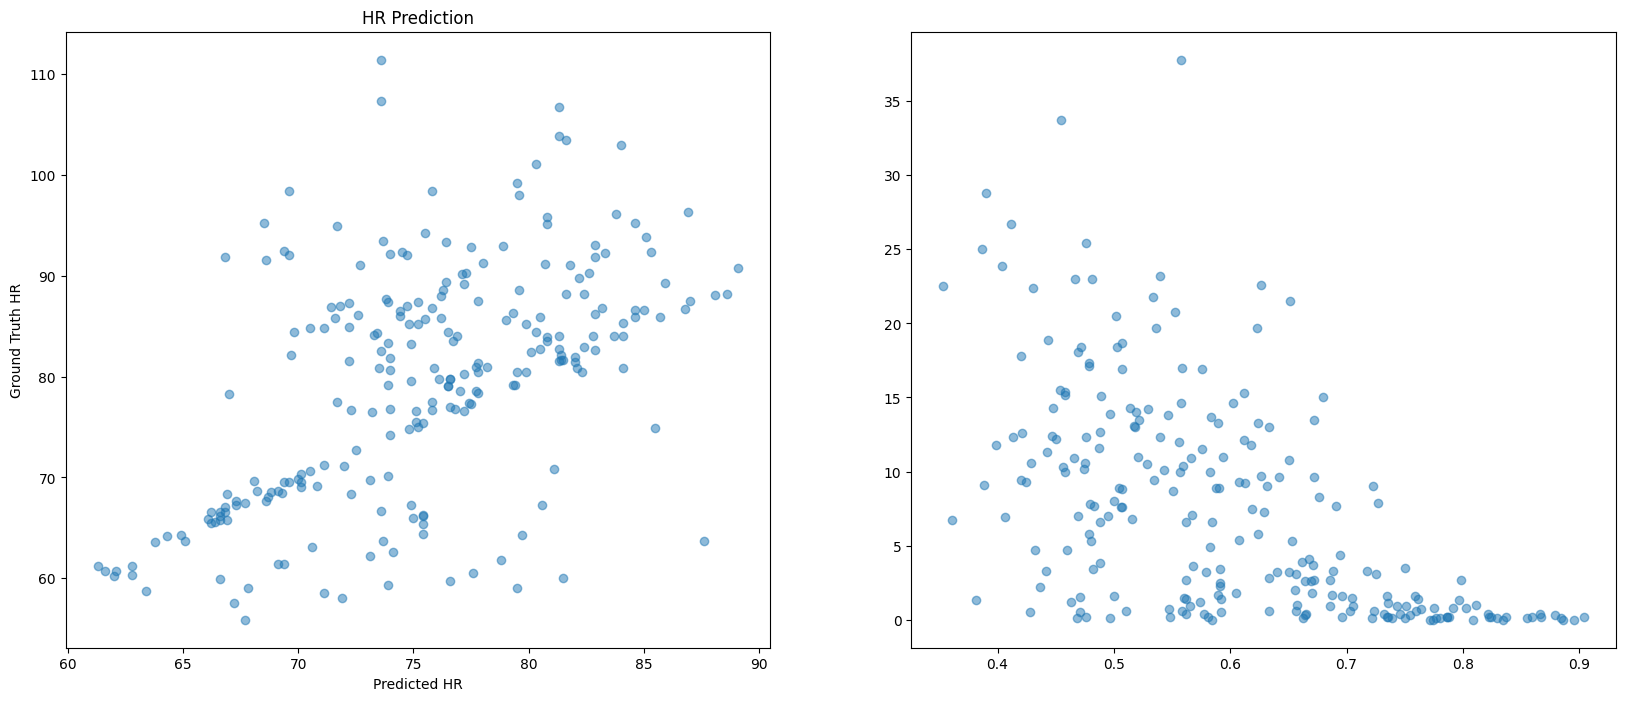

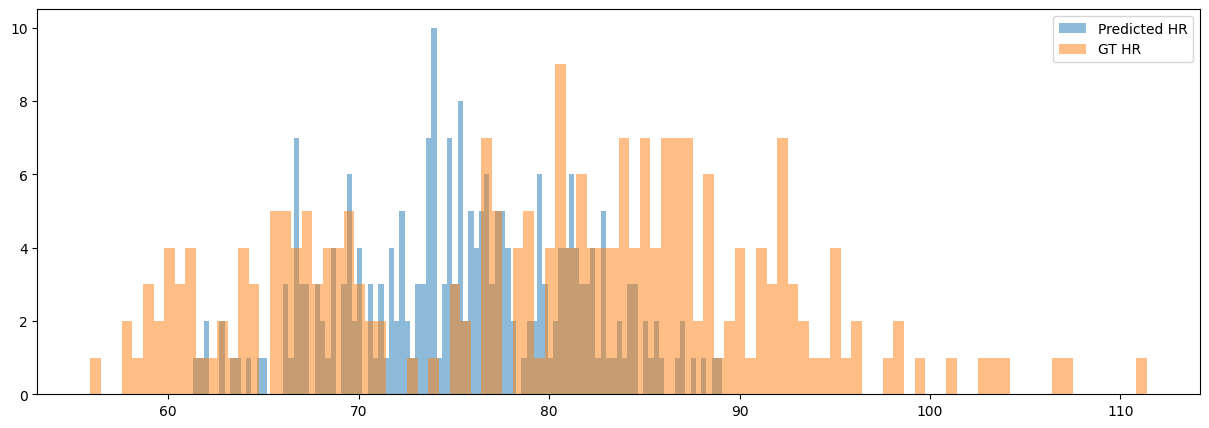

In [66]:
all_errors = np.abs(all_pred_hr - all_gt_hr)
# MAE, RMSE, MAPE, r
print(get_error_metric(all_pred_hr, all_gt_hr))
# Less than 15 bpm
print(np.sum(all_errors < 15), len(all_errors))
print(get_error_metric(all_pred_hr[all_errors < 15], all_gt_hr[all_errors < 15]))
# Less than 5 bpm
print(np.sum(all_errors < 5), len(all_errors))
print(get_error_metric(all_pred_hr[all_errors < 5], all_gt_hr[all_errors < 5]))
# Goodness > 0.5
print(len(all_errors[all_goodness > 0.5]), len(all_errors))
print(get_error_metric(all_pred_hr[all_goodness > 0.5], all_gt_hr[all_goodness > 0.5]))
# Goodness > 0.4
print(len(all_errors[all_goodness > 0.4]), len(all_errors))
print(get_error_metric(all_pred_hr[all_goodness > 0.4], all_gt_hr[all_goodness > 0.4]))
# 1x2 plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(all_pred_hr, all_gt_hr, 'o', alpha=0.5)
plt.xlabel('Predicted HR')
plt.ylabel('Ground Truth HR')
plt.title('HR Prediction') 
plt.subplot(1, 2, 2)
plt.plot(all_goodness, all_errors, 'o', alpha=0.5)
plt.show()

plt.figure(figsize=(15, 5))
plt.hist(np.array(all_pred_hr), bins=100, alpha=0.5, label='Predicted HR')
plt.hist(np.array(all_gt_hr), bins=100, alpha=0.5, label='GT HR')
plt.legend()
plt.show()

In [67]:
print(len(all_pred), len(all_gt), len(all_participant_task_chunk_list))
save_folder = "waveforms/rhythmformer_nir"
os.makedirs(save_folder, exist_ok=True)

with open(os.path.join(save_folder, "pred.pickle"), 'wb') as f:
    pickle.dump({'pred': all_pred, 'gt': all_gt, 'participant_task_chunk_id_list': all_participant_task_chunk_list}, f)
    
# with open(os.path.join(save_folder, "pred.pickle"), 'rb') as f:
#     data = pickle.load(f)
#     pred = data['pred']
#     gt = data['gt']
#     participant_task_chunk_id_list = data['participant_task_chunk_id_list']
# print(len(pred), len(gt), len(participant_task_chunk_id_list))

236 236 236
